In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm

# Importing the modules themselves for reloading
import TradePosition
import TouchArea
import TradingStrategy
import TouchDetection

# Reloading the modules to apply any changes
import importlib
importlib.reload(TradePosition)
importlib.reload(TouchArea)
importlib.reload(TradingStrategy)
importlib.reload(TouchDetection)

from TradePosition import TradePosition
from TouchArea import TouchArea
from TradingStrategy import StrategyParameters, TouchDetectionAreas, TradingStrategy 

from TouchDetection import BacktestTouchDetectionParameters, calculate_touch_detection_area, plot_touch_detection_areas, np_mean, np_median

In [2]:
# symbol = "NVDA"
symbol = "MSFT"
# symbol = "AAPL" #
# symbol = "TJX"
# symbol = "JNJ" #
# symbol = "AMZN"
# symbol = "AZN"
# symbol = "TSLA" #
# symbol = "TJX" #


start_date = "2017-01-01 00:00:00"
end_date =   "2018-01-01 00:00:00"

# start_date = "2024-01-01 00:00:00"
# end_date =   "2024-08-17 00:00:00"

# Usage example:
touch_params = BacktestTouchDetectionParameters(
    symbol=symbol,
    start_date=start_date,
    end_date=end_date,
    atr_period=15,
    level1_period=15,
    multiplier=1.4,
    min_touches=3,
    start_time=None,
    end_time='16:00',
    use_median=True,
    touch_area_width_agg=np_median,
    use_saved_bars=True,
    rolling_avg_decay_rate=0.85
    # export_bars_path=f'bars/bars_{symbol}_{start_date.split()[0]}_{end_date.split()[0]}.csv'
)

# touch_detection_areas = calculate_touch_detection_area(touch_params)

# touch_detection_areas = calculate_touch_detection_area(symbol, start_date, end_date, atr_period=15, level1_period=15, multiplier=1.4, min_touches=3, start_time=None, end_time='16:00', \
#     use_median=True, touch_area_width_agg=np_median, use_saved_bars=True, export_bars_path=f'bars_{symbol}_{start_date.split()[0]}_{end_date.split()[0]}.csv')


In [3]:
# a = touch_detection_areas.bars[touch_detection_areas.mask]['trade_count'].astype(float).describe()
# b = touch_detection_areas.bars[touch_detection_areas.mask]['volume'].astype(float).describe()
# c = touch_detection_areas.bars[touch_detection_areas.mask]['shares_per_trade'].astype(float).describe()
# pd.concat([a,b,c],axis=1)

In [4]:
zoom_start_date = start_date
zoom_end_date = end_date
# zoom_start_date = "2023-05-26 12:00:00"
# zoom_end_date = "2023-05-26 12:40:00"
# plot_touch_detection_areas(touch_detection_areas, zoom_start_date, zoom_end_date)

In [5]:
# len(touch_detection_areas['long_touch_area']) + len(touch_detection_areas['short_touch_area'])

In [6]:
params = StrategyParameters(
    initial_investment=10_000,
    do_longs=True,
    do_shorts=True,
    sim_longs=True,
    sim_shorts=True,
    
    use_margin=True,
    
    times_buying_power=1,
    
    soft_start_time = None, 
    soft_end_time = '15:50',
    
    # slippage_factor=0
)

# strategy = TradingStrategy(touch_detection_areas, params, export_trades_path='trades_output.csv')
# results = strategy.run_backtest()

In [7]:
# symbols = ['AAPL','INTC','JNJ','TSLA','MSFT','AMZN','ABBV']
# symbols = ['AAPL', 'MSFT', 'NVDA', 'TSLA', 'AMZN', 'JPM', 'GOOGL', 'META', 'XOM', 'CVX', 'UNH', 'PFE', 'KO', 'PG', 'BA', 'CAT']
# symbols = ['NVDA', 'JPM', 'GOOGL', 'META', 'XOM', 'CVX', 'UNH', 'PFE', 'KO', 'PG', 'BA', 'CAT']
# symbols = ['AAPL', 'MSFT', 'NVDA', 'GOOGL', 'AMZN', 'TSLA', 'JPM', 'BAC', 'META', 'T', 'VZ', 'XOM', 'CVX', 'JNJ', 'PFE', 'KO'] # generally high-liquidity from 2016 to present
symbols = ['AAPL', 'MSFT', 'NVDA', 'INTC', 'AMZN', 'TSLA', 'DIS', 'JPM', 'BAC', 'GOOGL', 'META', 'XOM', 'CVX', 'JNJ', 'PFE', 'KO'] # tests 3,4,5. generally high-liquidity from 2016 to 2019

In [8]:
trades_folder = 'test5/trades'
graphs_folder = 'test5/graphs'
xbp_folder = 'test5/xbp'

from IPython.utils import io
for s in symbols :
    touch_params.symbol = s
    touch_params.export_bars_path=f'bars/bars_{touch_params.symbol}_{start_date.split()[0]}_{end_date.split()[0]}.csv'
    
    # print(touch_params.symbol)
    # print(touch_params.export_bars_path)
    results_list = []
    
    # print(touch_params)
    touch_detection_areas = calculate_touch_detection_area(touch_params)
    # continue
    # for i in tqdm(list(np.arange(0.5, 4.01, 0.5))):
    for i in tqdm([1]):
        
        params.times_buying_power = i
        with io.capture_output() as captured:
            strategy = TradingStrategy(touch_detection_areas, params)
            
            if i == 1:
                strategy.export_trades_path=f'{trades_folder}/trades_{touch_params.symbol}_{start_date.split()[0]}_{end_date.split()[0]}.csv'
                strategy.export_graph_path=f'{graphs_folder}/graph_{touch_params.symbol}_{start_date.split()[0]}_{end_date.split()[0]}.png'
            
            balance, longs_executed, shorts_executed, balance_change, mean_profit_loss_pct, win_mean_profit_loss_pct, lose_mean_profit_loss_pct, winrate, total_costs, \
                avg_sub_pos, avg_transact, count_entry_adjust, count_entry_skip, count_exit_adjust, count_exit_skip, key_stats = \
                strategy.run_backtest()

        trades_executed = longs_executed + shorts_executed
        newrow = {
            'xBP': i,
            'net%': balance_change,
            'balance': balance,
            'cnt': trades_executed,
            # 'AvgPL%': mean_profit_loss_pct,
            # 'winAvgPL%': win_mean_profit_loss_pct,
            # 'loseAvgPL%': lose_mean_profit_loss_pct,
            'WR%': winrate,
            'TotalCosts': total_costs,
            # 'avg sub pos created': avg_sub_pos,
            # 'avg transactions': avg_transact,
            'entryAdjust': count_entry_adjust,
            'entrySkip': count_entry_skip,
            'exitAdjust': count_exit_adjust,
            'exitSkip': count_exit_skip,
            **key_stats
        }
        results_list.append(newrow)

    results = pd.DataFrame(results_list)
    # Format specific columns if needed
    results['xBP'] = results['xBP'].map('{:.1f}'.format)
    results['balance'] = results['balance'].map('${:.4f}'.format)
    results['TotalCosts'] = results['TotalCosts'].map('${:.4f}'.format)

    # Format all float columns
    float_columns = results.select_dtypes(include=['float64']).columns
    results[float_columns] = results[float_columns].applymap('{:.4f}'.format)

    # Display the results
    # pd.set_option('display.max_columns', None)
    filename = f'{xbp_folder}/xbp_{touch_params.symbol}_{start_date.split()[0]}_{end_date.split()[0]}.csv'
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    results.to_csv(filename,index=False)
    # results

Retrieved bars from bars/bars_AAPL_2017-01-01_2018-01-01.zip
                                   open   high    low  close  volume  \
symbol timestamp                                                       
AAPL   2017-01-03 04:03:00-05:00  26.85  26.85  26.85  26.85  1200.0   
       2017-01-03 04:04:00-05:00  26.85  26.85  26.85  26.85     0.0   
       2017-01-03 04:05:00-05:00  26.85  26.85  26.85  26.85     0.0   
       2017-01-03 04:06:00-05:00  26.88  26.88  26.88  26.88   664.0   
       2017-01-03 04:07:00-05:00  26.88  26.90  26.87  26.88  6280.0   
...                                 ...    ...    ...    ...     ...   
       2017-12-29 17:54:00-05:00  39.76  39.76  39.76  39.76     0.0   
       2017-12-29 17:55:00-05:00  39.76  39.76  39.76  39.76     0.0   
       2017-12-29 17:56:00-05:00  39.76  39.77  39.76  39.77  8924.0   
       2017-12-29 17:57:00-05:00  39.76  39.77  39.76  39.77     0.0   
       2017-12-29 17:58:00-05:00  39.78  39.78  39.78  39.78   952.0   

  

100%|██████████| 1/1 [01:02<00:00, 62.07s/it]
C:\Users\alexw\AppData\Local\Temp\ipykernel_31392\183012295.py:61: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results[float_columns] = results[float_columns].applymap('{:.4f}'.format)


Retrieved bars from bars/bars_MSFT_2017-01-01_2018-01-01.zip
                                   open   high    low  close  volume  \
symbol timestamp                                                       
MSFT   2017-01-03 04:00:00-05:00  56.94  56.94  56.94  56.94   268.0   
       2017-01-03 04:01:00-05:00  56.94  56.94  56.94  56.94  2800.0   
       2017-01-03 04:02:00-05:00  56.94  56.94  56.94  56.94     0.0   
       2017-01-03 04:03:00-05:00  56.94  56.94  56.94  56.94     0.0   
       2017-01-03 04:04:00-05:00  56.94  56.94  56.94  56.94     0.0   
...                                 ...    ...    ...    ...     ...   
       2017-12-29 17:47:00-05:00  79.34  79.34  79.34  79.34     0.0   
       2017-12-29 17:48:00-05:00  79.34  79.34  79.34  79.34     0.0   
       2017-12-29 17:49:00-05:00  79.34  79.34  79.34  79.34     0.0   
       2017-12-29 17:50:00-05:00  79.34  79.34  79.34  79.34     0.0   
       2017-12-29 17:51:00-05:00  79.33  79.33  79.33  79.33   203.0   

  

100%|██████████| 1/1 [01:23<00:00, 83.56s/it]
C:\Users\alexw\AppData\Local\Temp\ipykernel_31392\183012295.py:61: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results[float_columns] = results[float_columns].applymap('{:.4f}'.format)


Retrieved bars from bars/bars_NVDA_2017-01-01_2018-01-01.zip
                                   open   high    low  close   volume  \
symbol timestamp                                                        
NVDA   2017-01-03 04:05:00-05:00  2.667  2.667  2.667  2.667  24000.0   
       2017-01-03 04:06:00-05:00  2.667  2.667  2.667  2.667      0.0   
       2017-01-03 04:07:00-05:00  2.667  2.667  2.667  2.667      0.0   
       2017-01-03 04:08:00-05:00  2.667  2.667  2.667  2.667      0.0   
       2017-01-03 04:09:00-05:00  2.667  2.667  2.667  2.667      0.0   
...                                 ...    ...    ...    ...      ...   
       2017-12-29 17:55:00-05:00  4.780  4.780  4.780  4.780      0.0   
       2017-12-29 17:56:00-05:00  4.781  4.781  4.781  4.781   5280.0   
       2017-12-29 17:57:00-05:00  4.781  4.781  4.781  4.781      0.0   
       2017-12-29 17:58:00-05:00  4.781  4.781  4.781  4.781      0.0   
       2017-12-29 17:59:00-05:00  4.780  4.780  4.780  4.780   

100%|██████████| 1/1 [01:12<00:00, 72.17s/it]
C:\Users\alexw\AppData\Local\Temp\ipykernel_31392\183012295.py:61: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results[float_columns] = results[float_columns].applymap('{:.4f}'.format)


Retrieved bars from bars/bars_INTC_2017-01-01_2018-01-01.zip
                                   open   high    low  close  volume  \
symbol timestamp                                                       
INTC   2017-01-03 08:00:00-05:00  29.79  29.79  29.79  29.79   116.0   
       2017-01-03 08:01:00-05:00  29.81  29.81  29.81  29.81   165.0   
       2017-01-03 08:02:00-05:00  29.81  29.81  29.81  29.81     0.0   
       2017-01-03 08:03:00-05:00  29.81  29.81  29.81  29.81     0.0   
       2017-01-03 08:04:00-05:00  29.81  29.81  29.81  29.81     0.0   
...                                 ...    ...    ...    ...     ...   
       2017-12-29 17:50:00-05:00  38.67  38.71  38.67  38.71     0.0   
       2017-12-29 17:51:00-05:00  38.67  38.71  38.67  38.71     0.0   
       2017-12-29 17:52:00-05:00  38.67  38.71  38.67  38.71     0.0   
       2017-12-29 17:53:00-05:00  38.67  38.71  38.67  38.71     0.0   
       2017-12-29 17:54:00-05:00  38.67  38.67  38.67  38.67   200.0   

  

100%|██████████| 1/1 [01:03<00:00, 63.30s/it]
C:\Users\alexw\AppData\Local\Temp\ipykernel_31392\183012295.py:61: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results[float_columns] = results[float_columns].applymap('{:.4f}'.format)


Retrieved bars from bars/bars_AMZN_2017-01-01_2018-01-01.zip
                                   open   high    low  close   volume  \
symbol timestamp                                                        
AMZN   2017-01-03 04:01:00-05:00  37.82  37.82  37.82  37.82  15780.0   
       2017-01-03 04:02:00-05:00  37.82  37.82  37.82  37.82      0.0   
       2017-01-03 04:03:00-05:00  37.82  37.82  37.82  37.82      0.0   
       2017-01-03 04:04:00-05:00  37.82  37.82  37.82  37.82      0.0   
       2017-01-03 04:05:00-05:00  37.82  37.82  37.82  37.82      0.0   
...                                 ...    ...    ...    ...      ...   
       2017-12-29 17:50:00-05:00  58.39  58.39  58.39  58.39      0.0   
       2017-12-29 17:51:00-05:00  58.39  58.39  58.39  58.39      0.0   
       2017-12-29 17:52:00-05:00  58.39  58.39  58.39  58.39      0.0   
       2017-12-29 17:53:00-05:00  58.39  58.39  58.39  58.39      0.0   
       2017-12-29 17:54:00-05:00  58.38  58.38  58.38  58.38  1

100%|██████████| 1/1 [01:30<00:00, 90.26s/it]
C:\Users\alexw\AppData\Local\Temp\ipykernel_31392\183012295.py:61: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results[float_columns] = results[float_columns].applymap('{:.4f}'.format)


Retrieved bars from bars/bars_TSLA_2017-01-01_2018-01-01.zip
                                   open   high    low  close   volume  \
symbol timestamp                                                        
TSLA   2017-01-03 04:00:00-05:00  14.25  14.27  14.25  14.27  16305.0   
       2017-01-03 04:01:00-05:00  14.25  14.27  14.25  14.27      0.0   
       2017-01-03 04:02:00-05:00  14.25  14.27  14.25  14.27      0.0   
       2017-01-03 04:03:00-05:00  14.25  14.27  14.25  14.27      0.0   
       2017-01-03 04:04:00-05:00  14.25  14.27  14.25  14.27      0.0   
...                                 ...    ...    ...    ...      ...   
       2017-12-29 17:50:00-05:00  20.72  20.72  20.72  20.72      0.0   
       2017-12-29 17:51:00-05:00  20.72  20.72  20.72  20.72      0.0   
       2017-12-29 17:52:00-05:00  20.72  20.72  20.72  20.72      0.0   
       2017-12-29 17:53:00-05:00  20.72  20.72  20.72  20.72      0.0   
       2017-12-29 17:54:00-05:00  20.72  20.72  20.72  20.72   

100%|██████████| 1/1 [01:18<00:00, 78.07s/it]
C:\Users\alexw\AppData\Local\Temp\ipykernel_31392\183012295.py:61: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results[float_columns] = results[float_columns].applymap('{:.4f}'.format)


Retrieved bars from bars/bars_DIS_2017-01-01_2018-01-01.zip
                                    open    high     low   close  volume  \
symbol timestamp                                                           
DIS    2017-01-03 06:25:00-05:00  100.72  100.72  100.49  100.49  1200.0   
       2017-01-03 06:26:00-05:00  100.72  100.72  100.49  100.49     0.0   
       2017-01-03 06:27:00-05:00  100.72  100.72  100.49  100.49     0.0   
       2017-01-03 06:28:00-05:00  100.72  100.72  100.49  100.49     0.0   
       2017-01-03 06:29:00-05:00  100.72  100.72  100.49  100.49     0.0   
...                                  ...     ...     ...     ...     ...   
       2017-12-29 17:25:00-05:00  103.72  103.72  103.72  103.72     0.0   
       2017-12-29 17:26:00-05:00  103.72  103.72  103.72  103.72     0.0   
       2017-12-29 17:27:00-05:00  103.72  103.72  103.72  103.72     0.0   
       2017-12-29 17:28:00-05:00  103.72  103.72  103.72  103.72     0.0   
       2017-12-29 17:29:00-0

100%|██████████| 1/1 [02:04<00:00, 124.69s/it]
C:\Users\alexw\AppData\Local\Temp\ipykernel_31392\183012295.py:61: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results[float_columns] = results[float_columns].applymap('{:.4f}'.format)


Retrieved bars from bars/bars_JPM_2017-01-01_2018-01-01.zip
                                   open   high    low  close  volume  \
symbol timestamp                                                       
JPM    2017-01-03 04:00:00-05:00  69.93  69.93  69.93  69.93   100.0   
       2017-01-03 04:01:00-05:00  69.93  69.93  69.93  69.93     0.0   
       2017-01-03 04:02:00-05:00  69.93  69.93  69.93  69.93     0.0   
       2017-01-03 04:03:00-05:00  69.93  69.93  69.93  69.93     0.0   
       2017-01-03 04:04:00-05:00  69.93  69.93  69.93  69.93     0.0   
...                                 ...    ...    ...    ...     ...   
       2017-12-29 17:54:00-05:00  88.30  88.30  88.26  88.26     0.0   
       2017-12-29 17:55:00-05:00  88.30  88.30  88.26  88.26     0.0   
       2017-12-29 17:56:00-05:00  88.30  88.30  88.26  88.26     0.0   
       2017-12-29 17:57:00-05:00  88.30  88.30  88.30  88.30  1000.0   
       2017-12-29 17:58:00-05:00  88.30  88.30  88.30  88.30  1000.0   

   

100%|██████████| 1/1 [01:15<00:00, 75.29s/it]
C:\Users\alexw\AppData\Local\Temp\ipykernel_31392\183012295.py:61: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results[float_columns] = results[float_columns].applymap('{:.4f}'.format)


Retrieved bars from bars/bars_BAC_2017-01-01_2018-01-01.zip
                                   open   high    low  close  volume  \
symbol timestamp                                                       
BAC    2017-01-03 04:00:00-05:00  18.67  18.67  18.67  18.67   165.0   
       2017-01-03 04:01:00-05:00  18.67  18.67  18.67  18.67     0.0   
       2017-01-03 04:02:00-05:00  18.67  18.67  18.67  18.67     0.0   
       2017-01-03 04:03:00-05:00  18.67  18.67  18.67  18.67     0.0   
       2017-01-03 04:04:00-05:00  18.67  18.67  18.67  18.67     0.0   
...                                 ...    ...    ...    ...     ...   
       2017-12-29 17:55:00-05:00  25.29  25.29  25.29  25.29     0.0   
       2017-12-29 17:56:00-05:00  25.30  25.30  25.29  25.29   210.0   
       2017-12-29 17:57:00-05:00  25.30  25.30  25.29  25.29     0.0   
       2017-12-29 17:58:00-05:00  25.30  25.30  25.29  25.29     0.0   
       2017-12-29 17:59:00-05:00  25.29  25.29  25.29  25.29   250.0   

   

100%|██████████| 1/1 [00:59<00:00, 59.23s/it]
C:\Users\alexw\AppData\Local\Temp\ipykernel_31392\183012295.py:61: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results[float_columns] = results[float_columns].applymap('{:.4f}'.format)


Retrieved bars from bars/bars_GOOGL_2017-01-01_2018-01-01.zip
                                   open   high    low  close   volume  \
symbol timestamp                                                        
GOOGL  2017-01-03 04:01:00-05:00  39.96  39.96  39.96  39.96  12080.0   
       2017-01-03 04:02:00-05:00  39.96  39.96  39.96  39.96      0.0   
       2017-01-03 04:03:00-05:00  39.96  39.96  39.96  39.96      0.0   
       2017-01-03 04:04:00-05:00  39.96  39.96  39.96  39.96      0.0   
       2017-01-03 04:05:00-05:00  39.96  39.96  39.96  39.96      0.0   
...                                 ...    ...    ...    ...      ...   
       2017-12-29 17:24:00-05:00  52.56  52.56  52.56  52.56      0.0   
       2017-12-29 17:25:00-05:00  52.56  52.56  52.56  52.56      0.0   
       2017-12-29 17:26:00-05:00  52.56  52.56  52.56  52.56      0.0   
       2017-12-29 17:27:00-05:00  52.56  52.56  52.56  52.56   2200.0   
       2017-12-29 17:28:00-05:00  52.56  52.56  52.56  52.56  

100%|██████████| 1/1 [02:06<00:00, 126.13s/it]
C:\Users\alexw\AppData\Local\Temp\ipykernel_31392\183012295.py:61: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results[float_columns] = results[float_columns].applymap('{:.4f}'.format)


Retrieved bars from bars/bars_META_2017-01-01_2018-01-01.zip
                                    open    high     low   close  volume  \
symbol timestamp                                                           
META   2017-01-03 04:00:00-05:00  115.76  115.76  115.76  115.76   317.0   
       2017-01-03 04:01:00-05:00  115.76  115.76  115.76  115.76     0.0   
       2017-01-03 04:02:00-05:00  115.76  115.76  115.76  115.76     0.0   
       2017-01-03 04:03:00-05:00  115.76  115.76  115.76  115.76     0.0   
       2017-01-03 04:04:00-05:00  115.76  115.76  115.76  115.76     0.0   
...                                  ...     ...     ...     ...     ...   
       2017-12-29 17:51:00-05:00  175.79  175.79  175.79  175.79     0.0   
       2017-12-29 17:52:00-05:00  175.79  175.79  175.79  175.79     0.0   
       2017-12-29 17:53:00-05:00  175.79  175.79  175.79  175.79     0.0   
       2017-12-29 17:54:00-05:00  175.79  175.79  175.79  175.79     0.0   
       2017-12-29 17:55:00-

100%|██████████| 1/1 [01:14<00:00, 74.64s/it]
C:\Users\alexw\AppData\Local\Temp\ipykernel_31392\183012295.py:61: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results[float_columns] = results[float_columns].applymap('{:.4f}'.format)


Retrieved bars from bars/bars_XOM_2017-01-01_2018-01-01.zip
                                   open   high    low  close  volume  \
symbol timestamp                                                       
XOM    2017-01-03 07:22:00-05:00  63.59  63.59  63.59  63.59   315.0   
       2017-01-03 07:23:00-05:00  63.59  63.59  63.59  63.59     0.0   
       2017-01-03 07:24:00-05:00  63.59  63.59  63.59  63.59     0.0   
       2017-01-03 07:25:00-05:00  63.59  63.59  63.59  63.59     0.0   
       2017-01-03 07:26:00-05:00  63.59  63.59  63.59  63.59     0.0   
...                                 ...    ...    ...    ...     ...   
       2017-12-29 17:52:00-05:00  60.58  60.58  60.57  60.57     0.0   
       2017-12-29 17:53:00-05:00  60.58  60.58  60.57  60.57     0.0   
       2017-12-29 17:54:00-05:00  60.58  60.58  60.57  60.57     0.0   
       2017-12-29 17:55:00-05:00  60.58  60.58  60.57  60.57     0.0   
       2017-12-29 17:56:00-05:00  60.57  60.57  60.57  60.57   100.0   

   

100%|██████████| 1/1 [01:21<00:00, 81.15s/it]
C:\Users\alexw\AppData\Local\Temp\ipykernel_31392\183012295.py:61: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results[float_columns] = results[float_columns].applymap('{:.4f}'.format)


Retrieved bars from bars/bars_CVX_2017-01-01_2018-01-01.zip
                                   open   high    low  close  volume  \
symbol timestamp                                                       
CVX    2017-01-03 08:00:00-05:00  86.06  86.24  86.06  86.24   300.0   
       2017-01-03 08:01:00-05:00  86.06  86.24  86.06  86.24     0.0   
       2017-01-03 08:02:00-05:00  86.06  86.24  86.06  86.24     0.0   
       2017-01-03 08:03:00-05:00  86.06  86.24  86.06  86.24     0.0   
       2017-01-03 08:04:00-05:00  86.06  86.24  86.06  86.24     0.0   
...                                 ...    ...    ...    ...     ...   
       2017-12-29 17:29:00-05:00  94.83  94.83  94.83  94.83     0.0   
       2017-12-29 17:30:00-05:00  94.83  94.83  94.83  94.83     0.0   
       2017-12-29 17:31:00-05:00  94.83  94.83  94.83  94.83     0.0   
       2017-12-29 17:32:00-05:00  94.83  94.83  94.83  94.83     0.0   
       2017-12-29 17:33:00-05:00  94.26  94.26  93.99  93.99   400.0   

   

100%|██████████| 1/1 [02:21<00:00, 141.94s/it]
C:\Users\alexw\AppData\Local\Temp\ipykernel_31392\183012295.py:61: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results[float_columns] = results[float_columns].applymap('{:.4f}'.format)


Retrieved bars from bars/bars_JNJ_2017-01-01_2018-01-01.zip
                                    open    high     low   close  volume  \
symbol timestamp                                                           
JNJ    2017-01-03 04:00:00-05:00   94.10   94.10   94.10   94.10  1000.0   
       2017-01-03 04:01:00-05:00   94.10   94.10   94.10   94.10     0.0   
       2017-01-03 04:02:00-05:00   94.10   94.10   94.10   94.10     0.0   
       2017-01-03 04:03:00-05:00   94.10   94.10   94.10   94.10     0.0   
       2017-01-03 04:04:00-05:00   94.10   94.10   94.10   94.10     0.0   
...                                  ...     ...     ...     ...     ...   
       2017-12-29 16:31:00-05:00  116.97  116.97  116.97  116.97     0.0   
       2017-12-29 16:32:00-05:00  116.97  116.97  116.97  116.97     0.0   
       2017-12-29 16:33:00-05:00  116.97  116.97  116.97  116.97   400.0   
       2017-12-29 16:34:00-05:00  116.97  116.97  116.97  116.97     0.0   
       2017-12-29 16:35:00-0

100%|██████████| 1/1 [02:19<00:00, 139.75s/it]
C:\Users\alexw\AppData\Local\Temp\ipykernel_31392\183012295.py:61: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results[float_columns] = results[float_columns].applymap('{:.4f}'.format)


Retrieved bars from bars/bars_PFE_2017-01-01_2018-01-01.zip
                                   open   high    low  close  volume  \
symbol timestamp                                                       
PFE    2017-01-03 07:50:00-05:00  24.00  24.00  24.00  24.00   232.0   
       2017-01-03 07:51:00-05:00  24.00  24.00  24.00  24.00   419.0   
       2017-01-03 07:52:00-05:00  24.00  24.00  24.00  24.00     0.0   
       2017-01-03 07:53:00-05:00  24.00  24.00  24.00  24.00     0.0   
       2017-01-03 07:54:00-05:00  24.00  24.00  24.00  24.00     0.0   
...                                 ...    ...    ...    ...     ...   
       2017-12-29 17:50:00-05:00  27.68  27.68  27.68  27.68     0.0   
       2017-12-29 17:51:00-05:00  27.68  27.68  27.68  27.68   500.0   
       2017-12-29 17:52:00-05:00  27.68  27.68  27.68  27.68     0.0   
       2017-12-29 17:53:00-05:00  27.68  27.68  27.68  27.68     0.0   
       2017-12-29 17:54:00-05:00  27.68  27.68  27.68  27.68   280.0   

   

100%|██████████| 1/1 [04:50<00:00, 290.69s/it]
C:\Users\alexw\AppData\Local\Temp\ipykernel_31392\183012295.py:61: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results[float_columns] = results[float_columns].applymap('{:.4f}'.format)


Retrieved bars from bars/bars_KO_2017-01-01_2018-01-01.zip
                                   open   high    low  close  volume  \
symbol timestamp                                                       
KO     2017-01-03 07:24:00-05:00  32.80  32.80  32.80  32.80   150.0   
       2017-01-03 07:25:00-05:00  32.80  32.80  32.80  32.80     0.0   
       2017-01-03 07:26:00-05:00  32.80  32.80  32.80  32.80     0.0   
       2017-01-03 07:27:00-05:00  32.80  32.80  32.80  32.80     0.0   
       2017-01-03 07:28:00-05:00  32.80  32.80  32.80  32.80     0.0   
...                                 ...    ...    ...    ...     ...   
       2017-12-29 17:21:00-05:00  37.35  37.35  37.35  37.35     0.0   
       2017-12-29 17:22:00-05:00  37.35  37.35  37.35  37.35     0.0   
       2017-12-29 17:23:00-05:00  37.43  37.43  37.43  37.43   500.0   
       2017-12-29 17:24:00-05:00  37.42  37.43  37.42  37.43  2400.0   
       2017-12-29 17:25:00-05:00  37.36  37.36  37.36  37.36   808.0   

    

100%|██████████| 1/1 [01:56<00:00, 116.47s/it]
C:\Users\alexw\AppData\Local\Temp\ipykernel_31392\183012295.py:61: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results[float_columns] = results[float_columns].applymap('{:.4f}'.format)


In [9]:
# symbols = ['AAPL', 'MSFT', 'NVDA', 'TSLA', 'AMZN', 'JPM', 'GOOGL', 'META', 'XOM', 'CVX', 'UNH', 'PFE', 'KO', 'PG', 'BA', 'CAT','INTC','JNJ','ABBV'] # test2

In [10]:
results_combined = pd.DataFrame()
for s in symbols:
    fname = f'{xbp_folder}/xbp_{s}_{start_date.split()[0]}_{end_date.split()[0]}.csv'
    results = pd.read_csv(fname)
    results['symbol'] = s
    first_column = results.pop('symbol') 
    results.insert(0, 'symbol', first_column) 
    results_combined = pd.concat([results_combined, results],ignore_index=True)
results_combined['WinMax'] = results_combined[['LwinMax', 'SwinMax']].max(axis=1)
results_combined['LoseMin'] = results_combined[['LloseMin', 'SloseMin']].max(axis=1)
pd.set_option('display.max_rows', results_combined.shape[0])
pd.set_option('display.max_columns', results_combined.shape[1])
results_combined.loc[results_combined.xBP.isin({1,4})].sort_values('net%',ascending=False)

,symbol,xBP,net%,balance,cnt,WR%,TotalCosts,entryAdjust,entrySkip,exitAdjust,exitSkip,AllAvg,WinAvg,LoseAvg,LwinAvg,LwinMax,SwinAvg,SwinMax,LloseAvg,LloseMin,SloseAvg,SloseMin,WinMax,LoseMin
2,NVDA,1.0,3868.5005,$396850.0510,5979,38.7523,$51707.2194,4522,1791,339,154,0.1056,0.4443,-0.1088,0.4542,12.6103,0.4333,8.7853,-0.1074,-0.7834,-0.1102,-1.0267,12.6103,-0.7834
5,TSLA,1.0,2001.9299,$210192.9889,4029,40.1340,$11967.8625,2544,1009,239,678,0.1067,0.4362,-0.1142,0.4305,9.6591,0.4429,7.2020,-0.1089,-0.5758,-0.1199,-1.1955,9.6591,-0.5758
10,META,1.0,1195.4063,$129540.6349,7111,40.1069,$11218.0021,2640,1086,313,35,0.0457,0.1881,-0.0496,0.1927,4.9441,0.1827,4.5653,-0.0488,-0.6780,-0.0504,-0.3746,4.9441,-0.3746
8,BAC,1.0,1043.4004,$114340.0350,5140,36.6537,$10486.3277,2952,1267,469,0,0.0686,0.3227,-0.0784,0.3558,7.1212,0.2905,3.5994,-0.0763,-0.4656,-0.0805,-0.6767,7.1212,-0.4656
4,AMZN,1.0,888.0220,$98802.1990,4153,40.0433,$8712.6895,1109,461,51,764,0.0569,0.2360,-0.0627,0.2434,4.4678,0.2287,3.4923,-0.0605,-0.3707,-0.0649,-0.7924,4.4678,-0.3707
0,AAPL,1.0,796.2821,$89628.2092,5182,36.1443,$10489.9839,1252,555,95,0,0.0434,0.2136,-0.0529,0.2387,7.6833,0.1848,2.8265,-0.0523,-0.2758,-0.0536,-0.6028,7.6833,-0.2758
7,JPM,1.0,704.4790,$80447.9009,7265,39.7935,$6827.2950,4126,1606,634,113,0.0480,0.1991,-0.0519,0.2007,3.3599,0.1974,5.6192,-0.0502,-0.7311,-0.0536,-0.8894,5.6192,-0.7311
1,MSFT,1.0,642.7574,$74275.7427,7405,38.0689,$8183.4080,3369,1345,583,8,0.0370,0.1727,-0.0463,0.1816,4.7636,0.1626,2.6567,-0.0450,-0.3177,-0.0477,-0.3109,4.7636,-0.3109
3,INTC,1.0,376.1971,$47619.7055,6099,37.2028,$4761.5246,3600,1555,798,90,0.0417,0.2132,-0.0600,0.2121,6.4703,0.2144,5.8125,-0.0582,-0.9415,-0.0617,-0.4185,6.4703,-0.4185
6,DIS,1.0,319.9800,$41998.0035,4443,40.5807,$3480.8883,2026,949,336,1631,0.0408,0.1730,-0.0496,0.1699,3.4951,0.1761,3.8474,-0.0499,-1.7953,-0.0492,-0.4781,3.8474,-0.4781


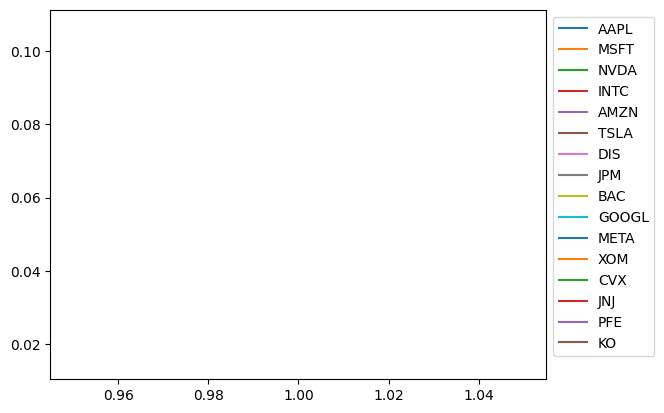

In [11]:
for s in symbols:
    fname = f'{xbp_folder}/xbp_{s}_{start_date.split()[0]}_{end_date.split()[0]}.csv'
    results = pd.read_csv(fname)
    plt.plot(results.xBP.astype(float).to_list(), results.AllAvg.astype(float).to_list(), label=s)
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.show()

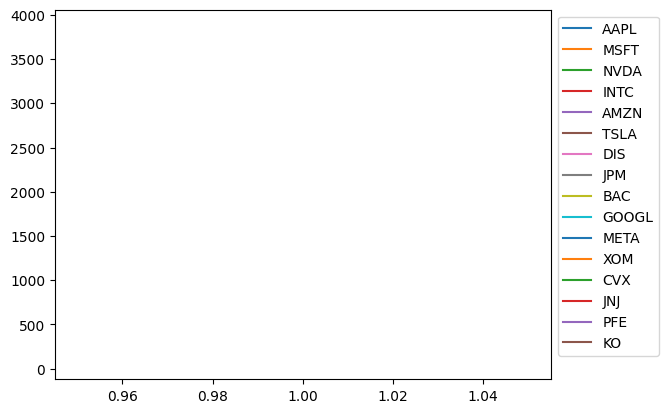

In [12]:
for s in symbols:
    fname = f'{xbp_folder}/xbp_{s}_{start_date.split()[0]}_{end_date.split()[0]}.csv'
    results = pd.read_csv(fname)
    plt.plot(results.xBP.astype(float).to_list(), results['net%'].astype(float).to_list(), label=s)
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.show()

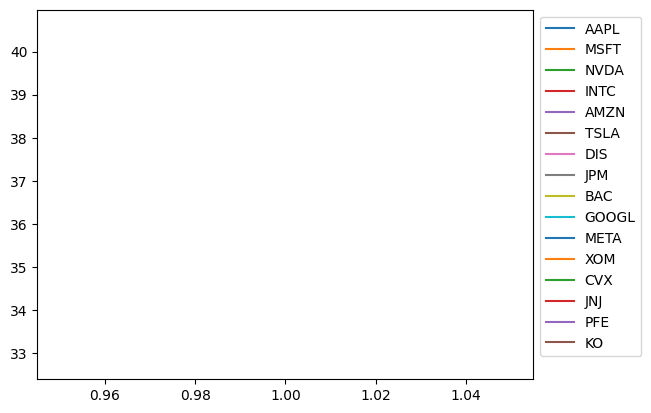

In [13]:
for s in symbols:
    fname = f'{xbp_folder}/xbp_{s}_{start_date.split()[0]}_{end_date.split()[0]}.csv'
    results = pd.read_csv(fname)
    plt.plot(results.xBP.astype(float).to_list(), results['WR%'].astype(float).to_list(), label=s)
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.show()